In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#Import basic libraries
%matplotlib inline


import os
import sys
import settings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from django_pandas.io import read_frame
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates

from matplotlib.dates import date2num

In [3]:
#Prepare to load stock data as pandas dataframe from source. In this case, prepare django
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

from stocks.models import Listing, Stock

In [4]:
#Asian paints
sid = 500820
stock = Stock.objects.get(security=sid)
listings = Listing.objects.filter(stock=stock)

#Read data into a dataframe
df = read_frame(listings, index_col='date')
for column in df.columns:
    if column != 'stock':
       df[column] = pd.to_numeric(df[column]) 
df = df.sort_index()
df = df.reindex(columns = ['opening', 'high', 'low', 'closing', 'traded'])
df.rename(columns={"opening": "Open", "high": "High", "low": "Low", "closing":"Close", "traded":"Volume"}, inplace=True)

In [6]:
#Optionally, filter out by date range
start_date = '2020-01-01'
end_date = '2021-12-31'
ticker = 'ASIANPAINTS'

df = df.loc[start_date:end_date]
h = df.Close.tolist()

[Source](https://towardsdatascience.com/programmatic-identification-of-support-resistance-trend-lines-with-python-d797a4a90530)

## Pivot Points

The first issue is to identify pivot points. Our points are going to be the closing prices at a given time. We can refer to these points in the chart as peaks and troughs or as local maxima and local minima.

There is a naive method for doing this as a pivot point would require the point preceding and succeeding to be both lower or both higher than a current point. A naive method has serious shortcomings however, as if the price remained constant for 2 consecutive days, no peak or trough would be detected. Nonetheless the indexes where this scenario did not occurred can be calculated relatively easily

In [7]:
#Naive method
minimaIdxs = np.flatnonzero(
                 df.Close.rolling(window=3, min_periods=1, center=True).aggregate(
                               lambda x: len(x) == 3 and x[0] > x[1] and x[2] > x[1])).tolist()
maximaIdxs = np.flatnonzero(
                 df.Close.rolling(window=3, min_periods=1, center=True).aggregate(
                   lambda x: len(x) == 3 and x[0] < x[1] and x[2] < x[1])).tolist()

## All peaks and troughs handling consecutive duplicates method

Certainly, collapsing the places where the price remains constant and the prior code with a different index retrieval would overcome this shortcoming and yield all of them, with a single time in the collapsed flat interval identified. Dropping consecutive duplicates before the above calculation is as simple as: `df.Close.loc[df.Close.shift(-1) != df.Close]`. However indexes need re-computation as they can have changed:

In [10]:
hs = df.Close.loc[df.Close.shift(-1) != df.Close]
x = hs.rolling(window=3, center=True).aggregate(lambda x: x[0] > x[1] and x[2] > x[1])
minimaIdxs = [df.index.get_loc(y) for y in x[x == 1].index]
x = hs.rolling(window=3, center=True).aggregate(lambda x: x[0] < x[1] and x[2] < x[1])
maximaIdxs = [df.index.get_loc(y) for y in x[x == 1].index]

## Numerical Differentiation method

However a far more elegant approach to this issue is to use the numerical derivative of the closing price to identify the points. The first derivative is the rate of change or effectively the momentum or velocity of the closing price, while the second derivative indicates the rate of change of the first derivative or its acceleration. Normal differentiation does not apply here as a discrete time series requires discrete numerical analysis tools. There are several advantages including that the numerical derivative will smooth out the data by considering all points in a given range from the point at which the rate of change is to be computed. For example the 5 points stencil method which considers some increment before and ahead, as well as a double increment before and ahead along with the point itself. The findiff library makes this computation easy and accurate even using higher order approximation methods:

In [11]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install findiff

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 6.2 MB 966 kB/s            
     |████████████████████████████████| 532 kB 12.6 MB/s            
  Created wheel for findiff: filename=findiff-0.8.9-py3-none-any.whl size=29227 sha256=d27fa05a6dffddc4f055a9961a6e409e99257b30cf6d7c923345ae54b01162f2
  Stored in directory: /home/anshul/.cache/pip/wheels/cd/c2/01/3073c488ab91444627e03d21ca5aa963028b0ec94b47e0691b
Successfully built findiff


In [19]:
from findiff import FinDiff #pip install findiff
dx = 1 #1 day interval
d_dx = FinDiff(0, dx, 1) #First partial derivative along 0th dimension with interval dx
d2_dx2 = FinDiff(0, dx, 2) #Second partial derivative along 0th dimension with interval dx

clarr = np.asarray(df.Close, dtype=np.float64)
mom = d_dx(clarr) #velocity is momentum
momacc = d2_dx2(clarr) #acceleration

With the first and second derivative calculated, a degree of smoothing has effectively occurred giving us the prominent peaks and troughs. They are the places where the first derivative is 0 as no momentum indicates a change of direction has occurred. The second derivative being positive or negative indicates a trough or peak, respectively as upward verses downward acceleration indicates the reversal in direction. However, an exact first derivative of 0 is very unlikely. Instead a value on one side of 0 followed by another is realistically what will occur since the point of 0 derivative occurred in between two days. So based on this, the higher or lower closing price will be chosen between two points where a 0 crossover has occurred:

In [20]:
def get_extrema(isMin):
  return [x for x in range(len(mom))
    if (momacc[x] > 0 if isMin else momacc[x] < 0) and
      (mom[x] == 0 or #slope is 0
        (x != len(mom) - 1 and #check next day
          (mom[x] > 0 and mom[x+1] < 0 and
           h[x] >= h[x+1] or
           mom[x] < 0 and mom[x+1] > 0 and
           h[x] <= h[x+1]) or
         x != 0 and #check prior day
          (mom[x-1] > 0 and mom[x] < 0 and
           h[x-1] < h[x] or
           mom[x-1] < 0 and mom[x] > 0 and
           h[x-1] > h[x])))]
minimaIdxs, maximaIdxs = get_extrema(True), get_extrema(False)

In [21]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install trendln --upgrade --no-cache-dir

In [23]:
import trendln
h = df.Close
print(type(h))
mins, maxs = trendln.calc_support_resistance(h, accuracy=8)

<class 'pandas.core.series.Series'>


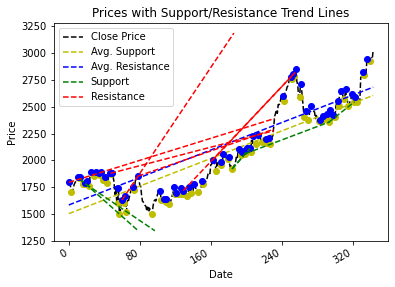

<Figure size 432x288 with 0 Axes>

In [25]:
fig = trendln.plot_support_resistance(df.Close, accuracy=2) # requires matplotlib - pip install matplotlib
plt.savefig('suppres.svg', format='svg')
plt.show()
plt.clf() #clear figure